In [3]:
# 1. Imports and path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

# file path - adjust if needed
DATA_PATH = "CloudWatch_Traffic_Web_Attack.csv"


In [4]:
# 2. Load the data and quick look
df = pd.read_csv(DATA_PATH)
print("shape:", df.shape)
display(df.head())
display(df.info())


shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

None

In [5]:
# 3. Basic cleaning & datetime parsing
# Make copies so we can experiment safely
df = df.copy()

# Convert known time columns to datetime if present
for col in ["creation_time", "end_time", "time"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Remove exact duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# Make country codes consistent if present
if "src_ip_country_code" in df.columns:
    df["src_ip_country_code"] = df["src_ip_country_code"].astype(str).str.upper().str.strip()

print("After cleaning: ", df.shape)


After cleaning:  (282, 16)


In [6]:
# 4. Quick checks (missing values, unique counts)
print("Missing per column:\n", df.isnull().sum())
print("\nUnique value counts (sample):")
for c in ["protocol","response.code","dst_port","detection_types"]:
    if c in df.columns:
        print(c, "->", df[c].nunique())


Missing per column:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

Unique value counts (sample):
protocol -> 1
response.code -> 1
dst_port -> 1
detection_types -> 1


In [7]:
# 5. Feature engineering
# session duration (seconds)
if ("creation_time" in df.columns) and ("end_time" in df.columns):
    df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds().fillna(0)

# avg_packet_size = (bytes_in + bytes_out) / max(1, duration_seconds)
df['bytes_in'] = pd.to_numeric(df['bytes_in'], errors='coerce').fillna(0)
df['bytes_out'] = pd.to_numeric(df['bytes_out'], errors='coerce').fillna(0)
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['duration_seconds'].replace(0, np.nan)
df['avg_packet_size'] = df['avg_packet_size'].fillna(0)

# ratio features
df['bytes_in_ratio'] = df['bytes_in'] / (df['bytes_in'] + df['bytes_out'] + 1e-9)

# flag known suspicious source if detection_types present (example)
if 'detection_types' in df.columns:
    df['is_waf_rule'] = (df['detection_types'].str.lower().fillna("") == 'waf_rule').astype(int)

display(df[['bytes_in','bytes_out','duration_seconds','avg_packet_size','bytes_in_ratio']].head())


,bytes_in,bytes_out,duration_seconds,avg_packet_size,bytes_in_ratio
0,5602,12990,600.0,30.986667,0.301312
1,30912,18186,600.0,81.830000,0.629598
2,28506,13468,600.0,69.956667,0.679135
3,30546,14278,600.0,74.706667,0.681465
4,6526,13892,600.0,34.030000,0.319620


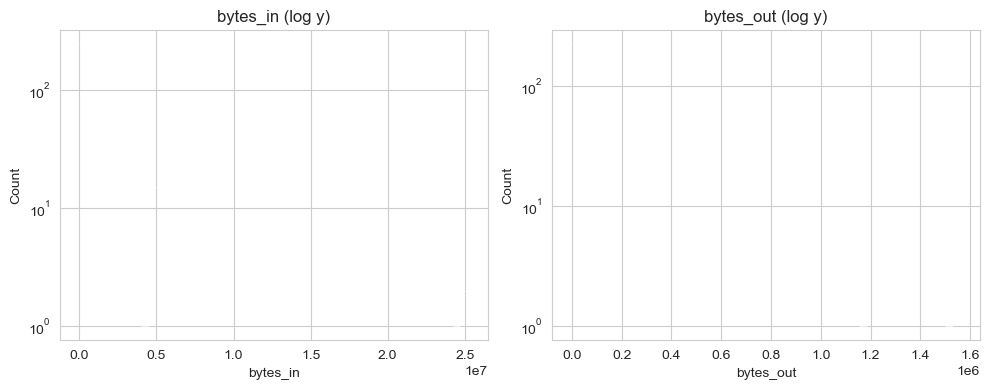

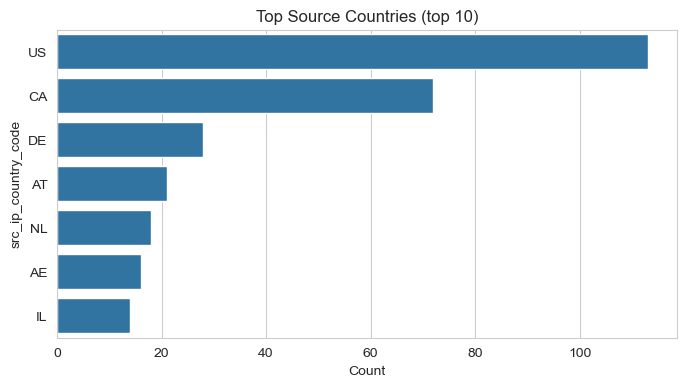

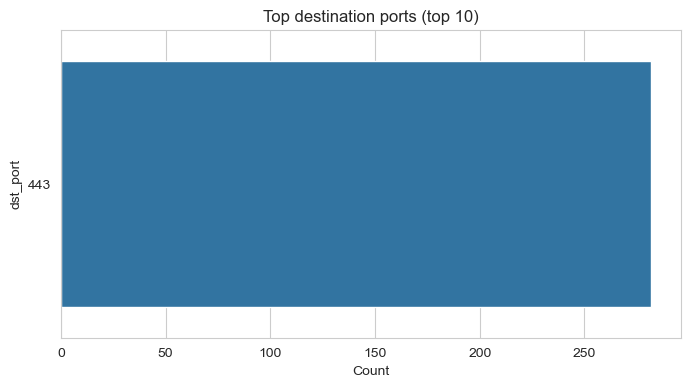

In [8]:
# 6. Exploratory Data Analysis (some quick plots)
sns.set_style("whitegrid")

# bytes_in and bytes_out distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['bytes_in'], bins=50, log_scale=(False, True))
plt.title("bytes_in (log y)")

plt.subplot(1,2,2)
sns.histplot(df['bytes_out'], bins=50, log_scale=(False, True))
plt.title("bytes_out (log y)")
plt.tight_layout()
plt.show()

# Top source countries
if "src_ip_country_code" in df.columns:
    plt.figure(figsize=(8,4))
    topc = df['src_ip_country_code'].value_counts().nlargest(10)
    sns.barplot(x=topc.values, y=topc.index)
    plt.title("Top Source Countries (top 10)")
    plt.xlabel("Count")
    plt.show()

# Destination ports frequency
if "dst_port" in df.columns:
    plt.figure(figsize=(8,4))
    top_ports = df['dst_port'].value_counts().nlargest(10)
    sns.barplot(x=top_ports.values, y=top_ports.index.astype(str))
    plt.title("Top destination ports (top 10)")
    plt.xlabel("Count")
    plt.show()


In [9]:
# 7. Prepare features for modeling (example: IsolationForest for anomalies)
feature_cols = ['bytes_in', 'bytes_out', 'duration_seconds', 'avg_packet_size', 'bytes_in_ratio']
X = df[feature_cols].fillna(0).astype(float)

# scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# save scaler for later
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [10]:
# 8. Unsupervised Anomaly Detection: Isolation Forest
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
df['anomaly_if'] = iso.fit_predict(X_scaled)  # -1 => anomaly, 1 => normal
df['anomaly_if'] = df['anomaly_if'].map({1: 0, -1: 1})  # 1 for suspicious

print("Anomalies found (IsolationForest):", df['anomaly_if'].sum())
display(df[df['anomaly_if'] == 1].head())


Anomalies found (IsolationForest): 15


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,observation_name,source.meta,source.name,time,detection_types,duration_seconds,avg_packet_size,bytes_in_ratio,is_waf_rule,anomaly_if
36,4190330,283456,2024-04-25 23:30:00+00:00,2024-04-25 23:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:30:00+00:00,waf_rule,600.0,7456.310000,0.936641,1,1
87,1215594,64362,2024-04-26 00:30:00+00:00,2024-04-26 00:40:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 00:30:00+00:00,waf_rule,600.0,2133.260000,0.949715,1,1
116,4827283,306181,2024-04-26 01:00:00+00:00,2024-04-26 01:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 01:00:00+00:00,waf_rule,600.0,8555.773333,0.940356,1,1
132,1889834,34306,2024-04-26 01:20:00+00:00,2024-04-26 01:30:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 01:20:00+00:00,waf_rule,600.0,3206.900000,0.982171,1,1
153,4869181,301752,2024-04-26 01:40:00+00:00,2024-04-26 01:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,...,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 01:40:00+00:00,waf_rule,600.0,8618.221667,0.941645,1,1


In [11]:
# 9. If you have or create a supervised label, train a Random Forest
# Example uses is_waf_rule (binary) if available; otherwise skip
if 'is_waf_rule' in df.columns and df['is_waf_rule'].nunique() > 1:
    y = df['is_waf_rule']
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("Classification report (RandomForest):")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    # save model
    joblib.dump(rf, "rf_model.joblib")
else:
    print("No supervised label column available (is_waf_rule absent or constant). Use unsupervised results.")


No supervised label column available (is_waf_rule absent or constant). Use unsupervised results.


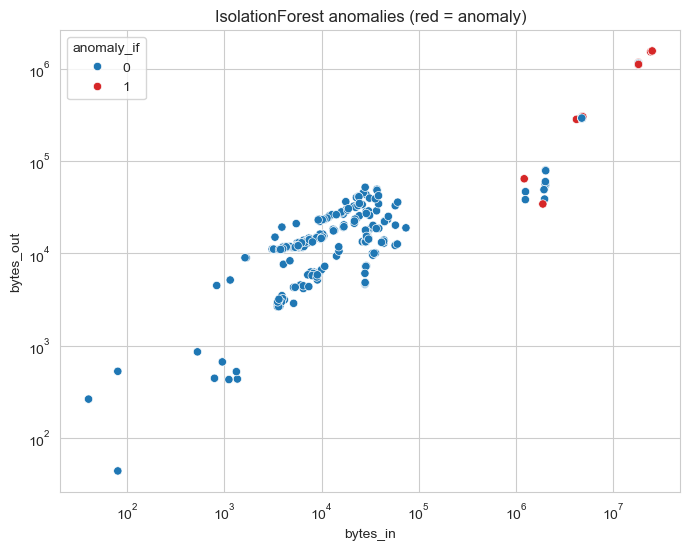

In [12]:
# 10. Visualize anomalies on bytes_in vs bytes_out scatter
plt.figure(figsize=(8,6))
palette = {0: 'C0', 1: 'C3'}
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly_if', data=df, palette=palette)
plt.xscale('log'); plt.yscale('log')
plt.title('IsolationForest anomalies (red = anomaly)')
plt.show()


In [13]:
# 11. Top suspicious IPs and summary
sus = df[df['anomaly_if'] == 1]
if not sus.empty:
    print("Top suspicious source IPs:")
    print(sus['src_ip'].value_counts().head(10))
    print("\nTop suspicious countries:")
    if 'src_ip_country_code' in sus.columns:
        print(sus['src_ip_country_code'].value_counts().head(10))
else:
    print("No anomalies flagged (check contamination param).")


Top suspicious source IPs:
src_ip
155.91.45.242     13
165.225.240.79     2
Name: count, dtype: int64

Top suspicious countries:
src_ip_country_code
US    13
NL     2
Name: count, dtype: int64


In [14]:
# 12. Save outputs (anomalies, transformed df)
df.to_csv("cloudwatch_with_features_and_anomalies.csv", index=False)
print("Saved results to: cloudwatch_with_features_and_anomalies.csv")


Saved results to: cloudwatch_with_features_and_anomalies.csv
